# KG construction with LLMs and utilization in RAG

This [Google Colab notebook](https://colab.research.google.com/drive/1sMQCfb_A9Otvvgjlso-Yb4oQfmPzULHl?usp=sharing):

*   provides detailed overview of the LlamaIndex framework, in particular KG related functionality
*   explores the use of KG in RAG for LLM response enchancement


Relevant links: </br>
LamaIndex [web](https://www.llamaindex.ai/), [github](https://github.com/run-llama/llama_index), [documentation](https://docs.llamaindex.ai/en/stable/)</br>
Zephyr 7B alpha [HuggingFace model card](https://huggingface.co/HuggingFaceH4/zephyr-7b-alpha) </br>
Neo4J AuraDB [web](https://neo4j.com/docs/aura/auradb/)

# Dependencies and Setup

In [ ]:
!pip install --upgrade llama-index transformers accelerate bitsandbytes cohere pyvis neo4j neo4jupyter py2neo circlify typing_extensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Google Colab locale fix

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# text format helper function

def bold(text):
  return f'\033[1m {text} \033[0m'

# Data

## Documents

[Documents](https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/usage_documents.html) and [nodes](https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/usage_nodes.html): [overview](https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/root.html)

Documents are split into nodes.


[NodeRelationship](https://docs.llamaindex.ai/en/stable/api/llama_index.schema.NodeRelationship.html)

In [ ]:
import json

from llama_index.schema import Document
from llama_index.schema import MetadataMode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
messages_path_ukr = "/content/drive/My Drive/Colab Notebooks/messages/messages_ukr.json"
messages_path_ru = "/content/drive/My Drive/Colab Notebooks/messages/messages_ru.json"

In [ ]:
with open(messages_path_ukr, 'r') as f:
  messages_ukr = json.loads(f.read())

print(f'Messages UKR length: {len(messages_ukr)}')

Messages UKR length: 1445


In [ ]:
with open(messages_path_ru, 'r') as f:
  messages_ru = json.loads(f.read())

print(f'Messages RU length: {len(messages_ru)}')

Messages RU length: 842


In [ ]:
docs_ukr = [Document(text=m['text'], metadata={'id': m['id'], 'timestamp': m['timestamp'], 'reactions': m['reactions']}) for m in messages_ukr]
for d in docs_ukr:
  d.excluded_llm_metadata_keys = ['id', 'timestamp', 'reactions']
print(f'Documents UKR length: {len(docs_ukr)}')

Documents UKR length: 1445


In [ ]:
docs_ru = [Document(text=m['text'], metadata={'id': m['id'], 'timestamp': m['timestamp'], 'reactions': m['reactions']}) for m in messages_ru]
for d in docs_ru:
  d.excluded_llm_metadata_keys = ['id', 'timestamp', 'reactions']
print(f'Documents RU length: {len(docs_ru)}')

Documents RU length: 842


# LLM

In [ ]:
import torch
from transformers import BitsAndBytesConfig
from llama_index.prompts import PromptTemplate
from llama_index.llms import HuggingFaceLLM

4b [quantization](https://www.qualcomm.com/news/onq/2019/03/heres-why-quantization-matters-ai) is used to improve efficiency

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
def messages_to_prompt(messages):
  prompt = ""
  for message in messages:
    if message.role == 'system':
      prompt += f"<|system|>\n{message.content}</s>\n"
    elif message.role == 'user':
      prompt += f"<|user|>\n{message.content}</s>\n"
    elif message.role == 'assistant':
      prompt += f"<|assistant|>\n{message.content}</s>\n"

  # ensure we start with a system prompt, insert blank if needed
  if not prompt.startswith("<|system|>\n"):
    prompt = "<|system|>\n</s>\n" + prompt

  # add final assistant prompt
  prompt = prompt + "<|assistant|>\n"

  return prompt

Local instance of opensource zephyr 7B is selected, as it is [best suited for most tasks](https://docs.llamaindex.ai/en/stable/module_guides/models/llms.html#open-source-llms) according to the docs

In [ ]:
llm = HuggingFaceLLM(
    model_name="HuggingFaceH4/zephyr-7b-alpha",
    tokenizer_name="HuggingFaceH4/zephyr-7b-alpha",
    query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
    context_window=3900,
    max_new_tokens=512,
    model_kwargs={"quantization_config": quantization_config},
    generate_kwargs={"temperature": 0.7, "top_k": 50, "top_p": 0.95, "do_sample": True},
    messages_to_prompt=messages_to_prompt,
    device_map="cuda:0",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

# LlamaIndex Setup

### Callback Manager setup

In [ ]:
from llama_index.callbacks import (
    CallbackManager,
    LlamaDebugHandler,
    CBEventType,
)

In [ ]:
from llama_index import ServiceContext

llama_debug = LlamaDebugHandler(print_trace_on_end=True)
callback_manager = CallbackManager([llama_debug])

### Service context setup

In [ ]:
from llama_index import ServiceContext

service_context = ServiceContext.from_defaults(callback_manager=callback_manager, llm=llm, embed_model="local:BAAI/bge-small-en-v1.5", chunk_size=256)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

### Logging setup

In [ ]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

# Knowledge Graph

In [ ]:
import networkx as nx

from IPython.display import display, HTML

from llama_index import KnowledgeGraphIndex
from llama_index.graph_stores import SimpleGraphStore
from llama_index.prompts.prompt_type import PromptType
from llama_index.storage.docstore import SimpleDocumentStore
from llama_index.storage.index_store import SimpleIndexStore
from llama_index.storage.storage_context import StorageContext

from pyvis.network import Network
from transformers import pipeline

KG constuction stats

In [ ]:
def print_llm_req_res():
  event_pairs = llama_debug.get_llm_inputs_outputs()

  for event_pair in event_pairs:
    print(f'\n***** {bold("LLM REQUEST")} *****\n')
    print(event_pair[0].payload['formatted_prompt'])
    print(f'\n***** {bold("LLM RESPONSE")} *****\n')
    print(event_pair[1].payload['completion'])

  llama_debug.flush_event_logs()

## mREBEL

In [ ]:
triplet_extractor_m = pipeline('translation_xx_to_yy', model='Babelscape/mrebel-large', tokenizer='Babelscape/mrebel-large', max_length=512, device='cuda:0')

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

In [ ]:
# Function to parse the generated text and extract the triplets
# mRebel outputs a specific format. This code is mostly copied from the model card!

def extract_triplets_m(input_text, timestamp, doc_id, debug=False):
    text = triplet_extractor_m.tokenizer.batch_decode([triplet_extractor_m(input_text, decoder_start_token_id=250058, src_lang="en_XX", tgt_lang="<triplet>", return_tensors=True, return_text=False)[0]["translation_token_ids"]])[0]
    if debug:
      print(bold('mREBEL response: '), text)

    properties = {
        'timestamp': timestamp,
        'doc_id': doc_id
    }

    triplets = []
    subject, relation, object_, object_type, subject_type = '', '', '', '', ''
    text = text.strip()
    current = 'x'

    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").replace("tp_XX", "").replace("__en__", "").split():
        if token == "<triplet>" or token == "<relation>":
            current = 't'
            if relation != '':
                triplets.append((subject.strip(), subject_type.strip(), relation.strip(), object_.strip(), object_type.strip(), properties))
                relation = ''
            subject = ''
        elif token.startswith("<") and token.endswith(">"):
            if current == 't' or current == 'o':
                current = 's'
                if relation != '':
                    triplets.append((subject.strip(), subject_type.strip(), relation.strip(), object_.strip(), object_type.strip(), properties))
                object_ = ''
                subject_type = token[1:-1]
            else:
                current = 'o'
                object_type = token[1:-1]
                relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append((subject.strip(), subject_type.strip(), relation.strip(), object_.strip(), object_type.strip(), properties))

    if debug:
      print(bold('Triplets: '), triplets)

    return triplets

## AuraDB Neo4J

In [ ]:
import neo4jupyter

from llama_index.graph_stores.neo4j import Neo4jGraphStore

from py2neo import Graph

In [ ]:
username_ukr = "neo4j"
password_ukr = "6IgL34YsZJpzwIiLYx-V_hHqYE299AR__7oswPrxtnQ"
url_ukr = "neo4j+ssc://04bd9156.databases.neo4j.io"
database_ukr = "neo4j"

In [ ]:
username_ru = "neo4j"
password_ru = "4b2QRi7Tn_XUyQo6HeRrXV3GGuFCvXaGJD1mitVXbGo"
url_ru = "neo4j+ssc://c52d965a.databases.neo4j.io"
database_ru = "neo4j"

## Framework extensions

In [ ]:
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple

from llama_index.constants import GRAPH_STORE_KEY
from llama_index.core.base_retriever import BaseRetriever
from llama_index.data_structs.data_structs import KG
from llama_index.graph_stores.types import GraphStore
from llama_index.indices.base import BaseIndex
from llama_index.schema import BaseNode, MetadataMode
from llama_index.service_context import ServiceContext
from llama_index.storage.docstore.types import RefDocInfo
from llama_index.storage.storage_context import StorageContext
from llama_index.utils import get_tqdm_iterable

In [ ]:
class KnowledgeGraphIndexCustom(KnowledgeGraphIndex):
    """Knowledge Graph Index Custom.

    Build a KG by extracting triplets, and leveraging the KG during query-time.

    Args:
        service_context (Optional[ServiceContext]): The service context to use.
        storage_context (Optional[StorageContext]): The storage context to use.
        graph_store (Optional[GraphStore]): The graph store to use.
        show_progress (bool): Whether to show tqdm progress bars. Defaults to False.
        include_embeddings (bool): Whether to include embeddings in the index.
            Defaults to False.
        max_object_length (int): The maximum length of the object in a triplet.
            Defaults to 128.
        kg_triplet_extract_fn (Optional[Callable]): The function to use for
            extracting triplets. Defaults to None.
        debug (bool): Whether debug mode is enabled. Defaults to False
    """

    def __init__(
        self,
        nodes: Optional[Sequence[BaseNode]] = None,
        index_struct: Optional[KG] = None,
        service_context: Optional[ServiceContext] = None,
        storage_context: Optional[StorageContext] = None,
        include_embeddings: bool = False,
        show_progress: bool = False,
        max_object_length: int = 128,
        kg_triplet_extract_fn: Optional[Callable] = None,
        debug: bool = False,
        **kwargs: Any,
    ) -> None:
        """Initialize params."""
        # need to set parameters before building index in base class.
        self._debug = debug

        super().__init__(
            nodes=nodes,
            index_struct=index_struct,
            service_context=service_context,
            storage_context=storage_context,
            include_embeddings=include_embeddings,
            show_progress=show_progress,
            max_object_length=max_object_length,
            kg_triplet_extract_fn=kg_triplet_extract_fn,
            **kwargs,
        )

    # Expanded tuple
    def _extract_triplets(self, text: str, timestamp: str, doc_id: str) -> List[Tuple[str, str, str, str, str, dict]]:
        return self._kg_triplet_extract_fn(text, timestamp, doc_id, self._debug)

    def _build_index_from_nodes(self, nodes: Sequence[BaseNode]) -> KG:
        """Build the index from nodes."""
        # do simple concatenation
        index_struct = self.index_struct_cls()
        nodes_with_progress = get_tqdm_iterable(
            nodes, self._show_progress, "Processing nodes"
        )
        for n in nodes_with_progress:
            timestamp = n.extra_info['timestamp']
            doc_id = n.ref_doc_id
            triplets = self._extract_triplets(n.get_content(metadata_mode=MetadataMode.LLM), timestamp, doc_id)

            if self._debug:
                print(f"> Extracted triplets: {triplets}")

            triplet_texts = []

            for triplet in triplets:
                # Expanded triplet
                subj, subj_t, rel, obj, obj_t, _ = triplet
                self.upsert_triplet(triplet)
                index_struct.add_node([subj, obj], n)
                triplet_texts.append(str([subj, subj_t, rel, obj, obj_t]))

            if self.include_embeddings:
                embed_model = self._service_context.embed_model
                embed_outputs = embed_model.get_text_embedding_batch(
                    triplet_texts, show_progress=self._show_progress
                )
                for rel_text, rel_embed in zip(triplet_texts, embed_outputs):
                    index_struct.add_to_embedding_dict(rel_text, rel_embed)

        return index_struct

    def _insert(self, nodes: Sequence[BaseNode], **insert_kwargs: Any) -> None:
        """Insert a document."""
        for n in nodes:
            triplets = self._extract_triplets(n.get_content(metadata_mode=MetadataMode.LLM))
            if self._debug:
                print(f"Extracted triplets: {triplets}")
            for triplet in triplets:
                # Expanded triplet
                subj, subj_t, rel, obj, obj_t, _ = triplet
                self.upsert_triplet(triplet)
                self._index_struct.add_node([subj, obj], n)
                triplet_str = str([subj, subj_t, rel, obj, obj_t])
                if (
                    self.include_embeddings
                    and triplet_str not in self._index_struct.embedding_dict
                ):
                    rel_embedding = (
                        self._service_context.embed_model.get_text_embedding(
                            triplet_str
                        )
                    )
                    self._index_struct.add_to_embedding_dict(triplet_str, rel_embedding)

    # Expanded triplet
    def upsert_triplet(self, triplet: Tuple[str, str, str, str, str, dict]) -> None:
        """Insert triplets.

        Used for manual insertion of KG triplets (in the form
        of (subject, relationship, object)).

        Args:
            triplet (str): Knowledge triplet

        """
        # Expanded triplet
        self._graph_store.upsert_triplet_complex(*triplet)

    # Expanded triplet
    def upsert_triplet_and_node(
        self, triplet: Tuple[str, str, str, str, str, dict], node: BaseNode
    ) -> None:
        """Upsert KG triplet and node.

        Calls both upsert_triplet and add_node.
        Behavior is idempotent; if Node already exists,
        only triplet will be added.

        Args:
            keywords (List[str]): Keywords to index the node.
            node (Node): Node to be indexed.

        """
        subj, _, _, obj, _, _ = triplet
        self.upsert_triplet(triplet)
        self.add_node([subj, obj], node)

In [ ]:
from llama_index.graph_stores.neo4j import node_properties_query
from llama_index.graph_stores.neo4j import rel_properties_query
from llama_index.graph_stores.neo4j import rel_query

In [ ]:
class Neo4jGraphStoreCustom(Neo4jGraphStore):
    def __init__(
        self,
        username: str,
        password: str,
        url: str,
        database: str = "neo4j",
        node_label: str = "zzz",
        debug=False,
        **kwargs: Any,
    ) -> None:
        self._debug = debug
        super().__init__(
            username=username,
            password=password,
            url=url,
            database=database,
            node_label=node_label
        )

    def upsert_triplet_complex(self, subj: str, subj_type: str, rel: str, obj: str, obj_type: str, properties: dict) -> None:
        subj_type = subj_type if subj_type else self.node_label
        obj_type = obj_type if obj_type else self.node_label

        """Add triplet."""
        query = f"""
        MERGE (n1:%s {{id:$subj}})
        ON CREATE
            SET n1:{subj_type}, n1.timestamps = {[properties['timestamp']]}, n1.doc_ids = {[properties['doc_id']]}
        ON MATCH
            SET n1:{subj_type}, n1.timestamps = n1.timestamps + '{properties['timestamp']}', n1.doc_ids = n1.doc_ids + '{properties['doc_id']}'
        MERGE (n2:%s {{id:$obj}})
        ON CREATE
            SET n2:{obj_type}, n2.timestamps = {[properties['timestamp']]}, n2.doc_ids = {[properties['doc_id']]}
        ON MATCH
            SET n2:{obj_type}, n2.timestamps = n2.timestamps + '{properties['timestamp']}', n2.doc_ids = n2.doc_ids + '{properties['doc_id']}'
        MERGE (n1)-[r1:`%s`]->(n2)
        ON CREATE
            SET r1.timestamps = {[properties['timestamp']]}, r1.doc_ids = {[properties['doc_id']]}
        ON MATCH
            SET r1.timestamps = r1.timestamps + '{properties['timestamp']}', r1.doc_ids = r1.doc_ids + '{properties['doc_id']}'
        """

        prepared_statement = query % (
            self.node_label,
            self.node_label,
            rel.replace(" ", "_").upper()
        )

        if self._debug:
          print(bold("Prepared statement"), "\n", prepared_statement)

        with self._driver.session(database=self._database) as session:
            session.run(prepared_statement, {"subj": subj, "obj": obj})

## KG construction and indexing

In [ ]:
graph_store_custom_ukr = Neo4jGraphStoreCustom(
    username=username_ukr,
    password=password_ukr,
    url=url_ukr,
    database=database_ukr,
    debug=False,
)

storage_context_ukr = StorageContext.from_defaults(graph_store=graph_store_custom_ukr)

In [ ]:
# computationally heavy operation
index_custom_ukr = KnowledgeGraphIndexCustom.from_documents(
    docs_ukr,
    storage_context=storage_context_ukr,
    service_context=service_context,
    kg_triplet_extract_fn=extract_triplets_m,
    include_embeddings=True,
    debug=False,
    node_label='zzz'
)

In [ ]:
graph_store_custom_ru = Neo4jGraphStoreCustom(
    username=username_ru,
    password=password_ru,
    url=url_ru,
    database=database_ru,
    debug=False,
)

storage_context_ru = StorageContext.from_defaults(graph_store=graph_store_custom_ru)

In [ ]:
# computationally heavy operation
index_custom_ru = KnowledgeGraphIndexCustom.from_documents(
    docs_ru,
    storage_context=storage_context_ru,
    service_context=service_context,
    kg_triplet_extract_fn=extract_triplets_m,
    include_embeddings=True,
    debug=False,
    node_label='zzz'
)

KG info

In [ ]:
kg_ukr = Graph(url_ukr, auth=(username_ukr, password_ukr))

In [ ]:
print('Number of nodes in produced KG UKR:')
kg_ukr.run("MATCH (n) RETURN count(n) as node_count")

Number of nodes in produced KG UKR:


node_count 
------------
       2216

In [ ]:
print('Number of relations in produced KG UKR:')
kg_ukr.run("MATCH ()-[r]->() RETURN count(r) as rel_count")

Number of relations in produced KG UKR:


rel_count 
-----------
      2785

In [ ]:
kg_ru = Graph(url_ru, auth=(username_ru, password_ru))

In [ ]:
print('Number of nodes in produced KG RU:')
kg_ru.run("MATCH (n) RETURN count(n) as node_count")

Number of nodes in produced KG RU:


node_count 
------------
       1504

In [ ]:
print('Number of relations in produced KG RU:')
kg_ru.run("MATCH ()-[r]->() RETURN count(r) as rel_count")

Number of relations in produced KG RU:


rel_count 
-----------
      1235

## Persisting KG to Google Drive

In [ ]:
kg_persist_dir_ukr = "/content/drive/My Drive/Colab Notebooks/kg_persist_ukr"
kg_persist_dir_ru = "/content/drive/My Drive/Colab Notebooks/kg_persist_ru"

In [ ]:
!rm -r "$kg_persist_dir_ukr"
!mkdir -p "$kg_persist_dir_ukr"

In [ ]:
!rm -r "$kg_persist_dir_ru"
!mkdir -p "$kg_persist_dir_ru"

rm: cannot remove '/content/drive/My Drive/Colab Notebooks/kg_persist_ru': No such file or directory


In [ ]:
storage_context_ukr.persist(persist_dir=kg_persist_dir_ukr)

In [ ]:
storage_context_ru.persist(persist_dir=kg_persist_dir_ru)

## Loading KG from Google Drive

Load neo4j graph store

In [ ]:
graph_store_ukr = Neo4jGraphStoreCustom(
    username=username_ukr,
    password=password_ukr,
    url=url_ukr,
    database=database_ukr,
)

In [ ]:
graph_store_ru = Neo4jGraphStoreCustom(
    username=username_ru,
    password=password_ru,
    url=url_ru,
    database=database_ru,
)

Load storage context

In [ ]:
doc_store_ukr = SimpleDocumentStore.from_persist_dir(persist_dir=kg_persist_dir_ukr)
doc_store_ru = SimpleDocumentStore.from_persist_dir(persist_dir=kg_persist_dir_ru)

In [ ]:
storage_context_l_ukr = StorageContext.from_defaults(
    docstore=doc_store_ukr,
    index_store=SimpleIndexStore.from_persist_dir(persist_dir=kg_persist_dir_ukr),
    graph_store=graph_store_ukr
)

In [ ]:
storage_context_l_ru = StorageContext.from_defaults(
    docstore=doc_store_ru,
    index_store=SimpleIndexStore.from_persist_dir(persist_dir=kg_persist_dir_ru),
    graph_store=graph_store_ru
)

Load index

In [ ]:
index_custom_l_ukr = KnowledgeGraphIndexCustom(
    index_struct=storage_context_l_ukr.index_store.index_structs()[0],
    service_context=service_context,
    storage_context=storage_context_l_ukr,
    include_embeddings=True,
    debug=False,
    node_label='zzz'
)

**********
Trace: index_construction
**********


In [ ]:
index_custom_l_ru = KnowledgeGraphIndexCustom(
    index_struct=storage_context_l_ru.index_store.index_structs()[0],
    service_context=service_context,
    storage_context=storage_context_l_ru,
    include_embeddings=True,
    debug=False,
    node_label='zzz'
)

**********
Trace: index_construction
**********


# Analysis

In [ ]:
from datetime import datetime, timedelta

format = "%m/%d/%Y, %H:%M:%S"

def to_dt(dt_str):
  return datetime.strptime(dt_str, format)

In [ ]:
label_to_color = {
    'loc': '#A8201A',
    'concept': '#0F8B8D',
    'time': '#EE4266',
    'per': '#775B59',
    'org': '#143642',
    'eve': '#EC9A29',
    'media': '#84DCCF',
    'num': '#EF626C',
    'misc': '#312F2F',
}

In [ ]:
def filter_unique(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [ ]:
def filter_timestamps(node, interval_start, interval_end):
  n_t, n_d = [], []

  for t, d in zip(node['timestamps'], node['doc_ids']):
    t_dt = to_dt(t)
    if interval_start <= t_dt <= interval_end:
      n_t.append(t_dt)
      n_d.append(d)

  node['timestamps'], node['doc_ids'] = filter_unique(n_t), filter_unique(n_d)

In [ ]:
def add_size(node):
  node['size'] = len(node['timestamps'])

In [ ]:
def get_most_mentioned_entites(graph_store, limit=None, interval_start=None, interval_end=None):
  interval_start = to_dt(interval_start) if interval_start else datetime.min
  interval_end = to_dt(interval_end) if interval_end else datetime.max

  nodes = graph_store.query("MATCH (n:zzz) RETURN n.id as id, labels(n) as labels, n.timestamps as timestamps, n.doc_ids as doc_ids")
  for node in nodes:
    filter_timestamps(node, interval_start, interval_end)
    add_size(node)

  nodes.sort(key=lambda n: n['size'])

  if limit:
    nodes = nodes[-limit:]

  return nodes

In [ ]:
import circlify
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
def draw_nodes_bubbles(nodes, filename=None):
  # compute circle positions:
  circles = circlify.circlify(
      [n['size'] for n in nodes],
      show_enclosure=False,
      target_enclosure=circlify.Circle(x=0, y=0, r=1)
  )

  # Create just a figure and only one subplot
  fig, ax = plt.subplots(figsize=(15,15))

  # Title
  ax.set_title('Mostly mentioned entities')

  # Remove axes
  ax.axis('off')

  # Find axis boundaries
  lim = max(
      max(
          abs(circle.x) + circle.r,
          abs(circle.y) + circle.r,
      )
      for circle in circles
  )
  plt.xlim(-lim, lim)
  plt.ylim(-lim, lim)

  # list of labels
  labels = [f'{n["id"]}: {n["size"]}' for n in nodes]
  colors = [label_to_color[n['labels'][-1]] for n in nodes]

  # print circles
  for circle, label, color in zip(circles, labels, colors):
      x, y, r = circle
      ax.add_patch(plt.Circle((x, y), r*0.9, alpha=0.9, linewidth=0, facecolor=color, edgecolor="black"))
      plt.annotate(label, (x,y ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor=color, boxstyle='round', pad=.5))

  plt.show()

  if filename:
    plt.savefig(filename)
    plt.close()

In [ ]:
def draw_nodes_barh(nodes, filename=None):
  fig, ax = plt.subplots(figsize=(15,10))

  for i, node in enumerate(nodes):
      # For each timestamp in the node, create a bar with width 1 hour
      bars = [(ts, timedelta(hours=10)) for ts in node['timestamps']]
      ax.broken_barh(bars, (i-0.4, 0.8), color=label_to_color[node['labels'][-1]])

  # Set the yticks to be the node ids
  ax.set_yticks(range(len(nodes)))
  ax.set_yticklabels([node['id'] for node in nodes])

  # Format xaxis to show dates and times
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

  plt.xticks(rotation=55)
  plt.show()

  if filename:
    plt.savefig(filename)
    plt.close()

In [ ]:
import plotly.graph_objects as go

In [ ]:
def get_aggr_reactions(node, ref_doc_info, filename=None):

  data = dict()

  for doc_id in node['doc_ids']:
    for k, v in ref_doc_info[doc_id].metadata['reactions'].items():
      data[v[0]] = data.get(v[0], 0) + v[1]

  data = {k: v for k, v in sorted(data.items(), key=lambda item: -item[1])}

  # Create a Figure
  fig = go.Figure(go.Bar(
      x=list(data.keys()),
      y=list(data.values()),
      marker_color=list(label_to_color.values())
  ))

  # Set labels
  fig.update_layout(
      title=f'{node["id"]} Reactions Bar Chart',
      xaxis_title='Emoji',
      yaxis_title='Count',
  )

  # Show the plot
  fig.show()

  if filename:
    fig.savefig(filename)

In [ ]:
plot_dir = "/content/drive/My Drive/Colab Notebooks/plots/"

## Over all data

In [ ]:
nodes_ukr = get_most_mentioned_entites(graph_store_ukr, limit=10)
nodes_ru = get_most_mentioned_entites(graph_store_ru, limit=10)

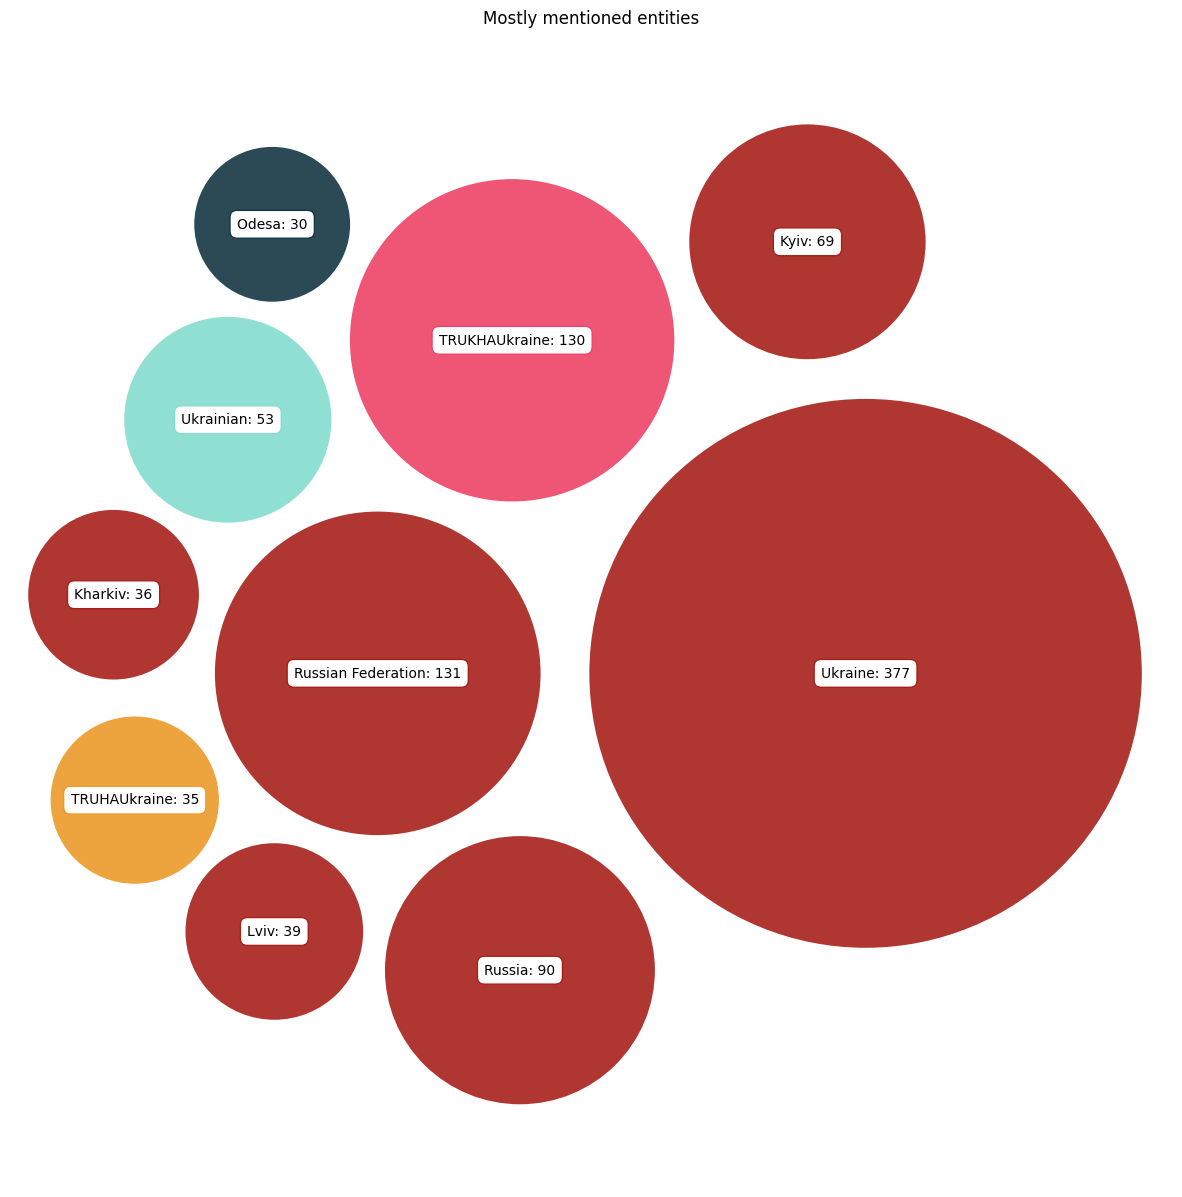

In [ ]:
draw_nodes_bubbles(nodes_ukr)

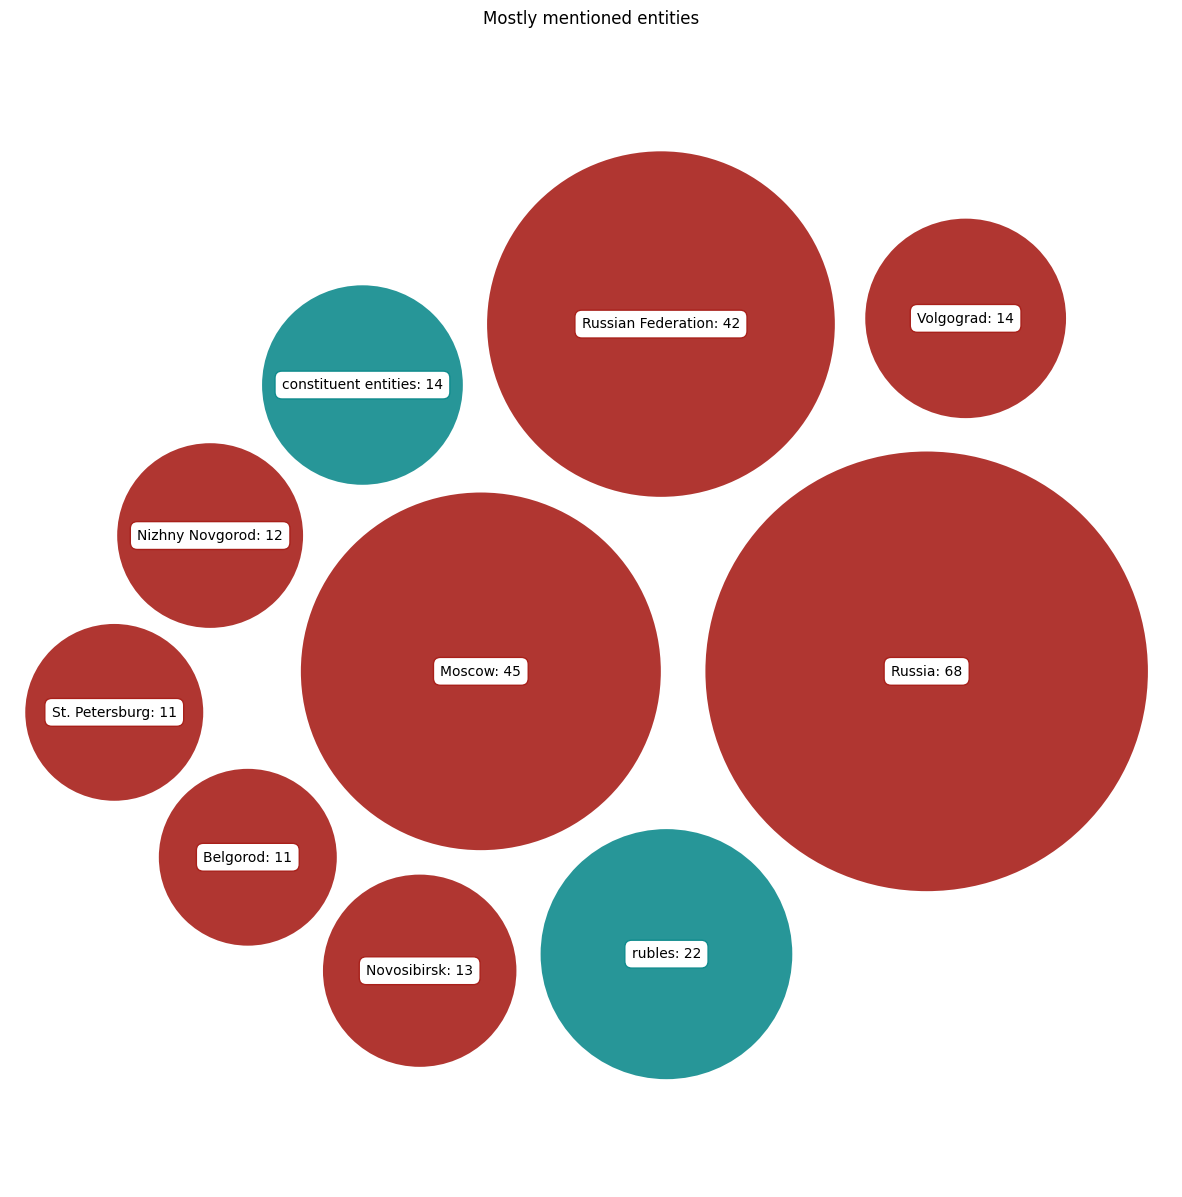

In [ ]:
draw_nodes_bubbles(nodes_ru)

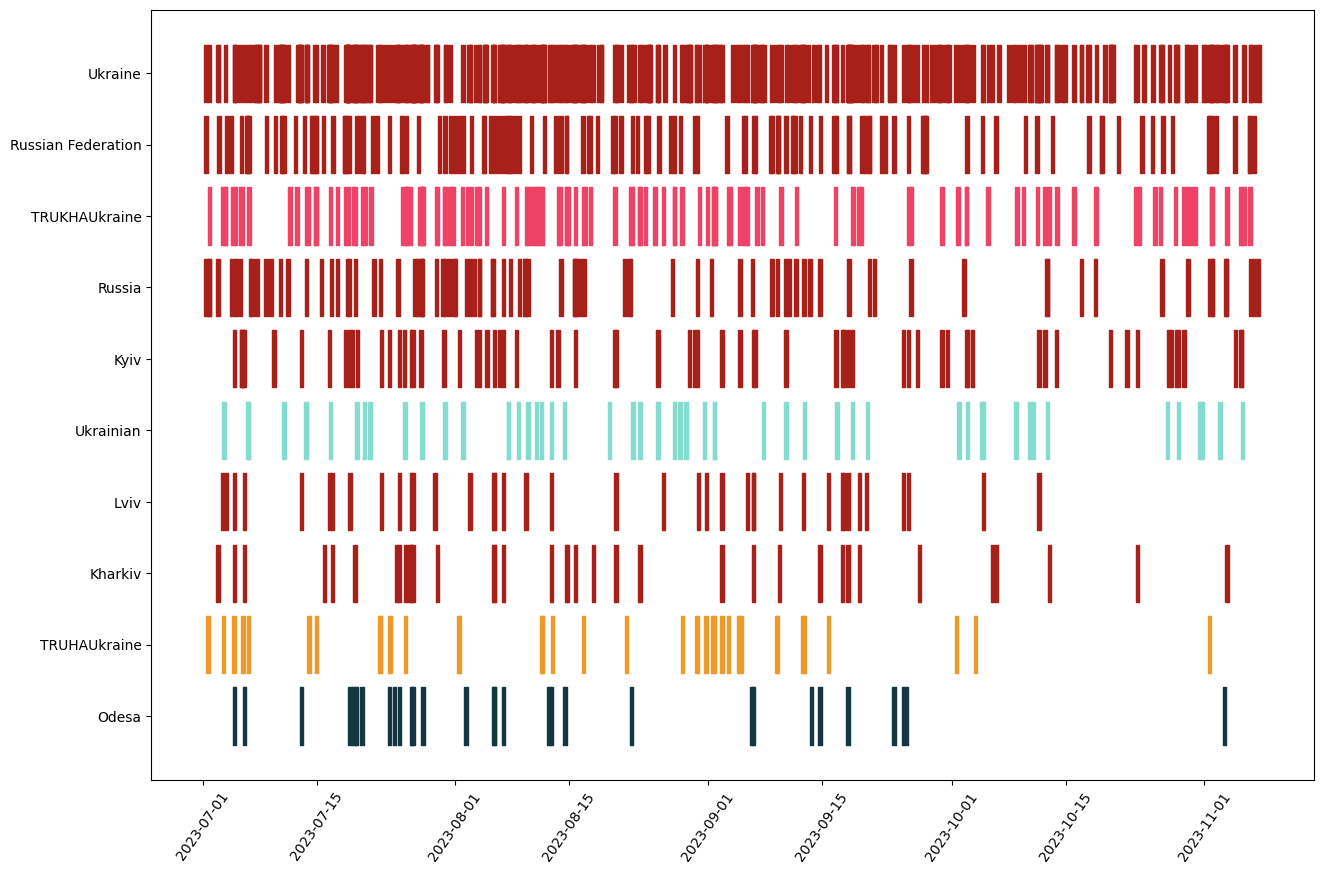

In [ ]:
draw_nodes_barh(nodes_ukr)

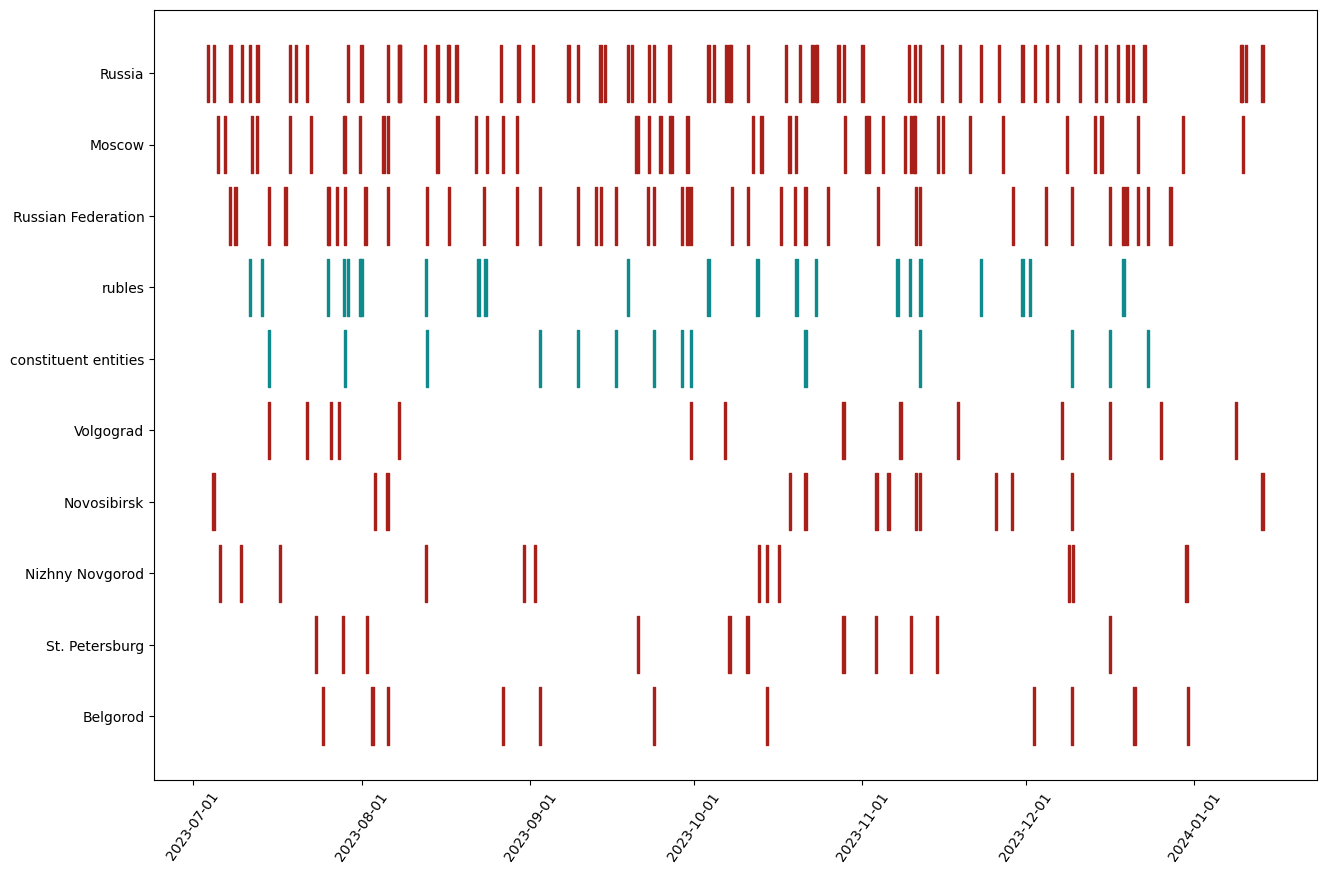

In [ ]:
draw_nodes_barh(nodes_ru)

## Attacks on Israel
10/01/2023 - 11/01/2023

In [ ]:
nodes_is_ukr = get_most_mentioned_entites(graph_store_ukr, limit=10, interval_start="10/01/2023, 00:00:00", interval_end="11/01/2023, 00:00:00")
nodes_is_ru = get_most_mentioned_entites(graph_store_ru, limit=10, interval_start="10/01/2023, 00:00:00", interval_end="11/01/2023, 00:00:00")

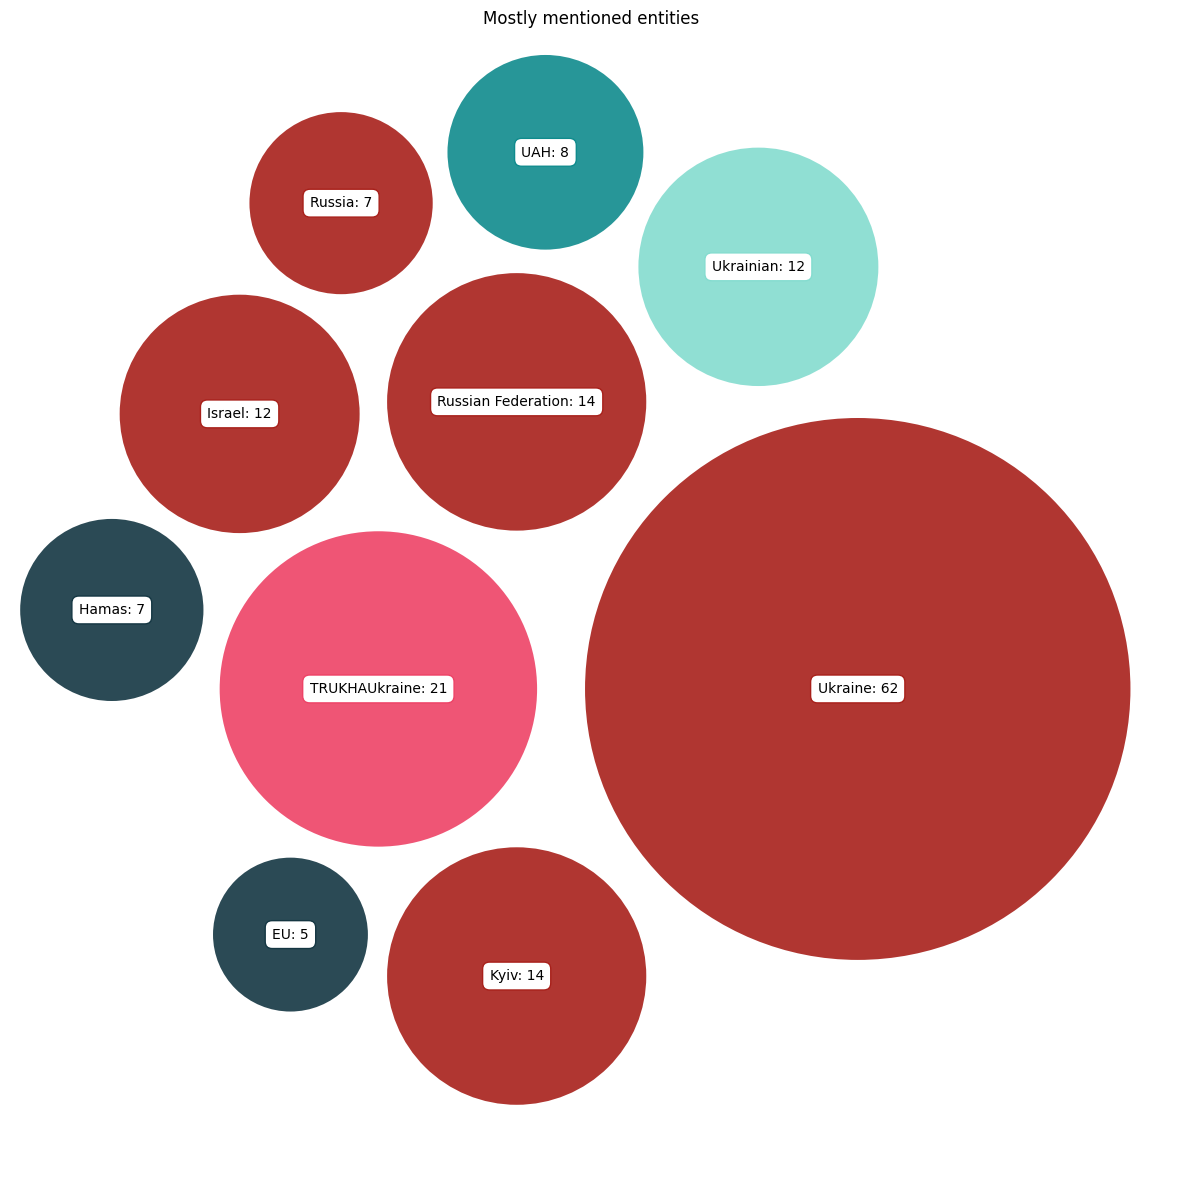

In [ ]:
draw_nodes_bubbles(nodes_is_ukr)

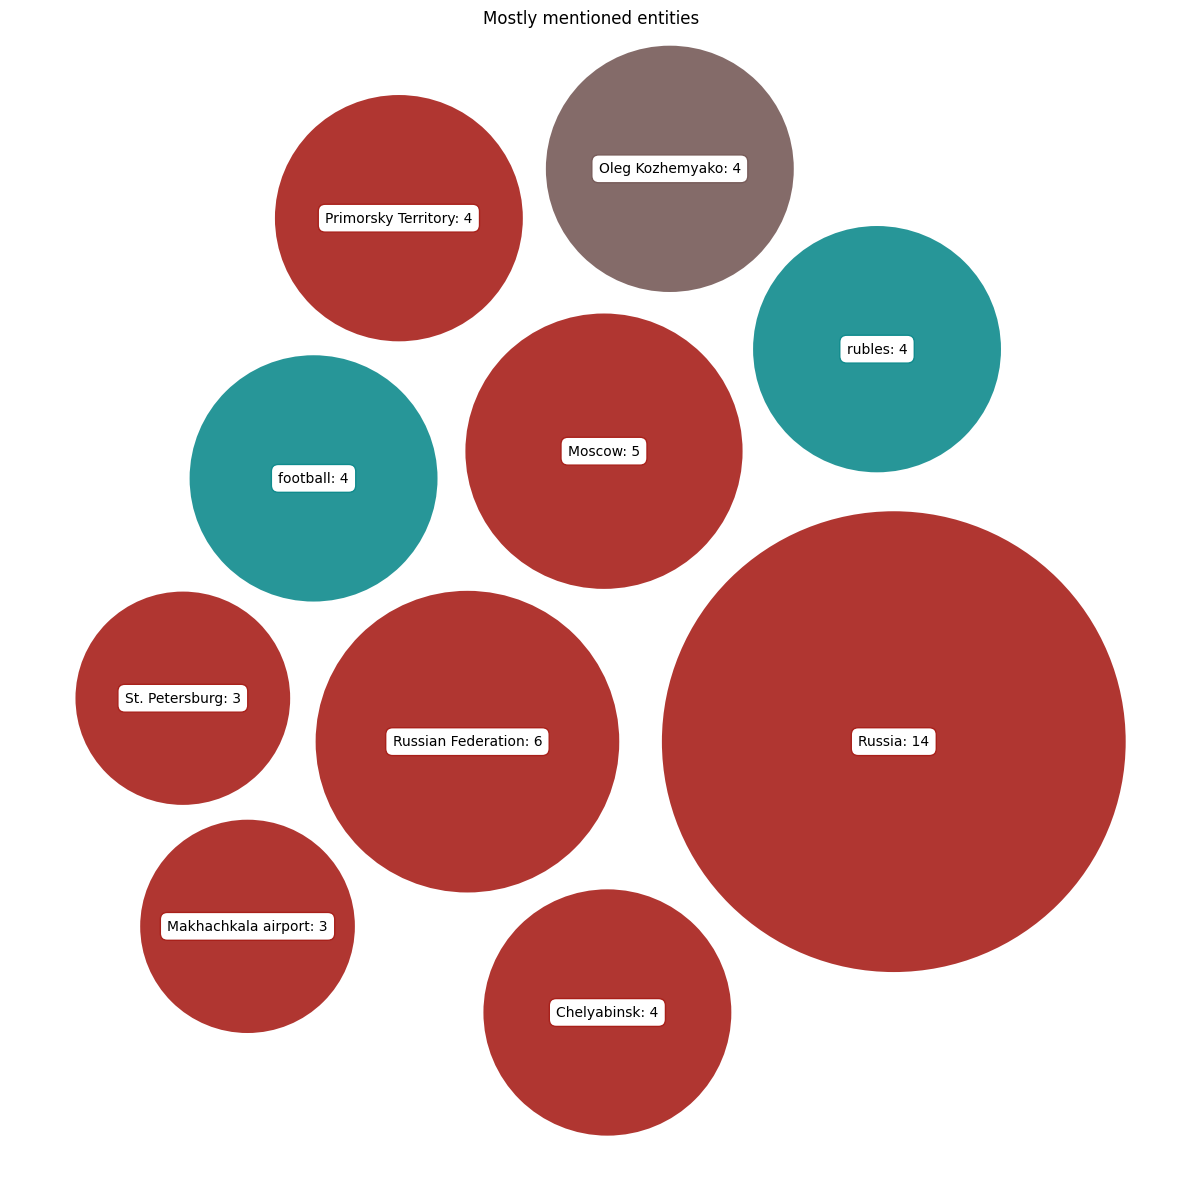

In [ ]:
draw_nodes_bubbles(nodes_is_ru)

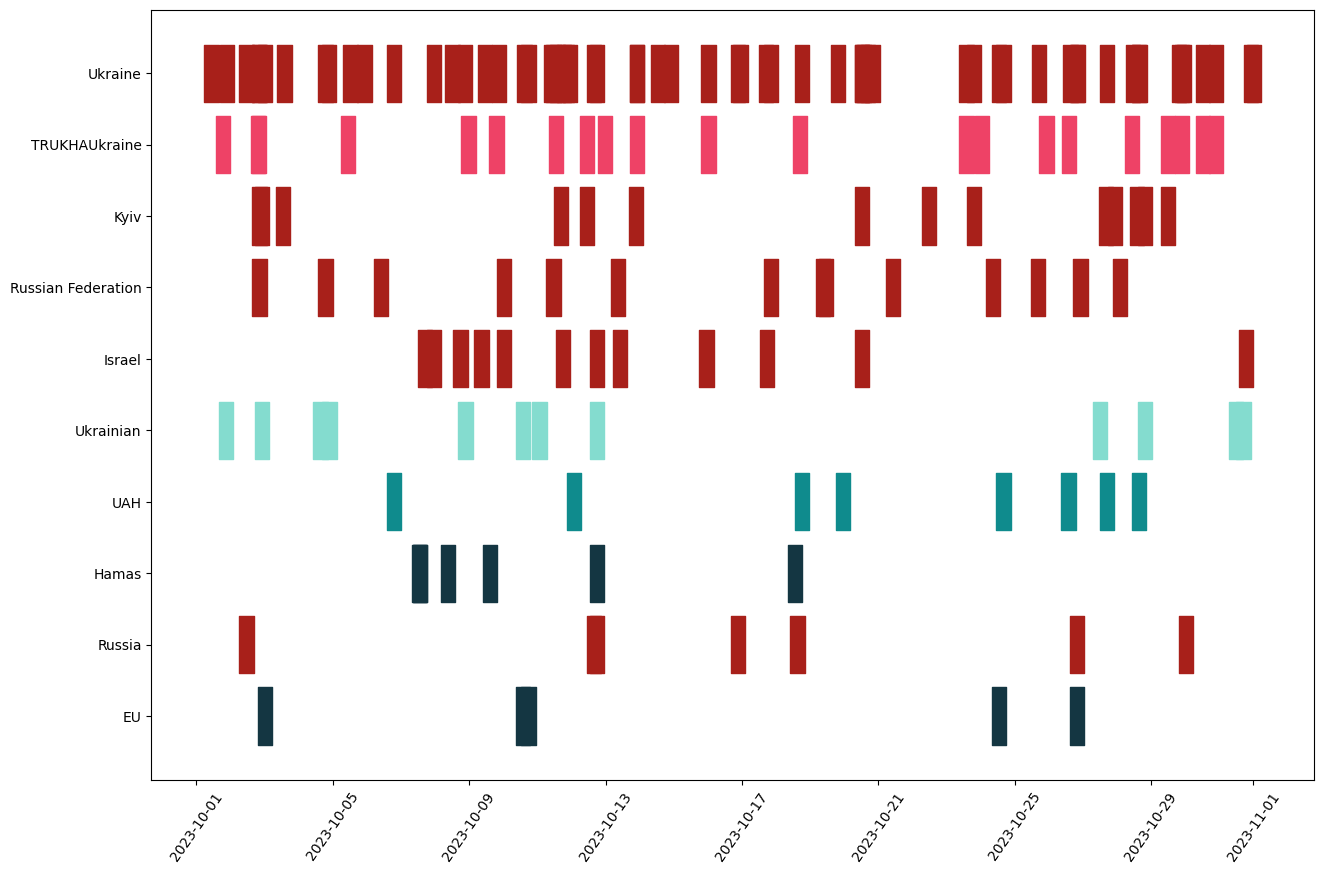

In [ ]:
draw_nodes_barh(nodes_is_ukr)

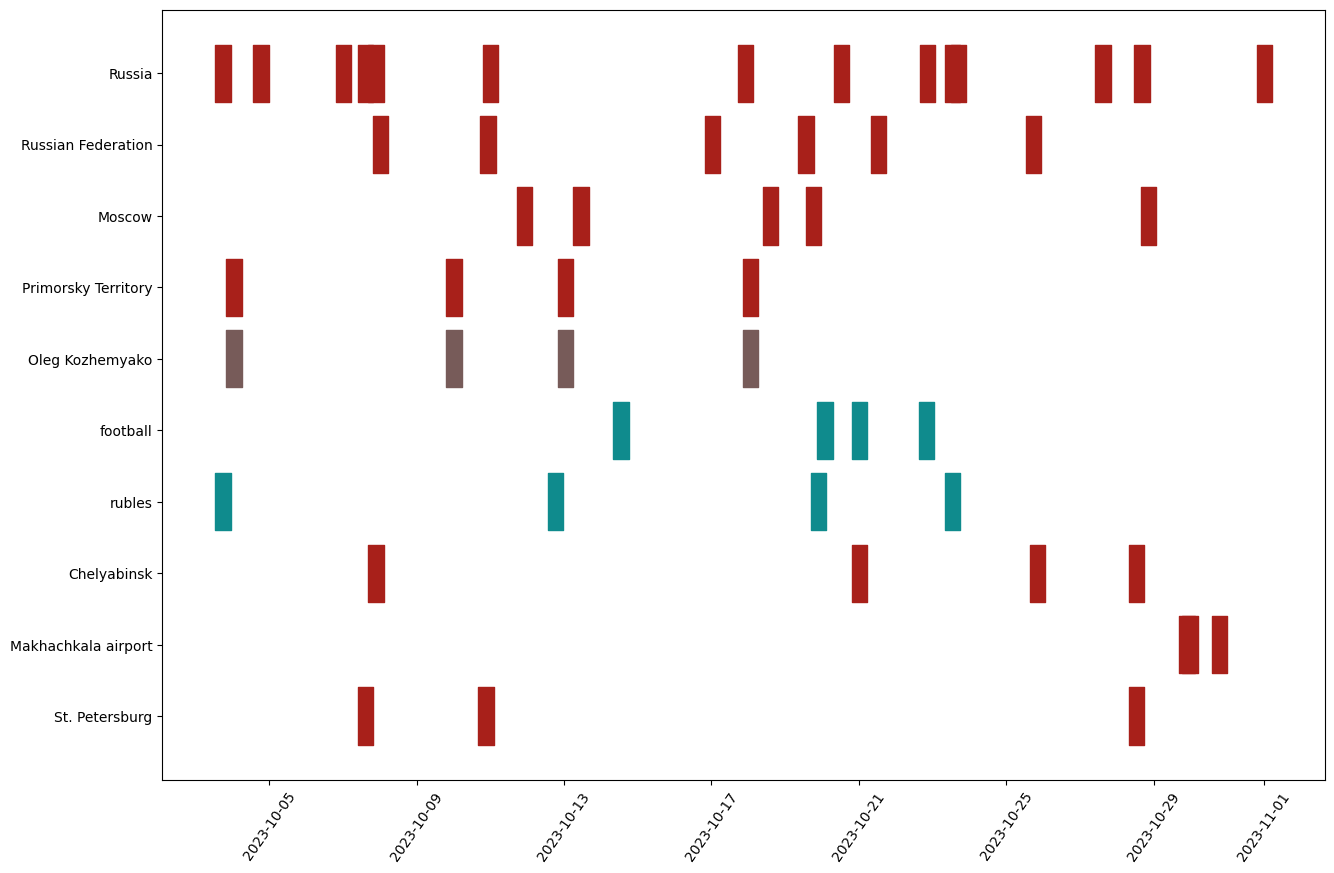

In [ ]:
draw_nodes_barh(nodes_is_ru)

# RAG

In [ ]:
from textwrap import wrap

In [ ]:
def printf(res):
  print("\n".join(wrap(str(res))))

In [ ]:
import re

from llama_index.bridge.pydantic import BaseModel
from llama_index.query_engine.retriever_query_engine import RetrieverQueryEngine
from llama_index.postprocessor.types import BaseNodePostprocessor
from llama_index.prompts import BasePromptTemplate
from llama_index.schema import QueryBundle, QueryType
from llama_index.callbacks.schema import CBEventType, EventPayload
from llama_index.core.response.schema import RESPONSE_TYPE

from llama_index.response_synthesizers import (
    BaseSynthesizer,
    ResponseMode,
    get_response_synthesizer,
)

from typing import cast
from llama_index.chat_engine.types import BaseChatEngine, ChatMode

In [ ]:
def format_emoji_name(name):
  name = re.sub(r':', '', name)
  name = re.sub(r'_', ' ', name)
  return name

In [ ]:
class RetrieverQueryEngineInterval(RetrieverQueryEngine):
    def __init__(
        self,
        retriever: BaseRetriever,
        response_synthesizer: Optional[BaseSynthesizer] = None,
        node_postprocessors: Optional[List[BaseNodePostprocessor]] = None,
        callback_manager: Optional[CallbackManager] = None,
        interval_start=None,
        interval_end=None,
        reactions=False,
    ) -> None:
        self._interval_start = datetime.strptime(interval_start, format) if interval_start else datetime.min
        self._interval_end = datetime.strptime(interval_end, format) if interval_end else datetime.max
        self._reactions = reactions
        super().__init__(
            retriever=retriever,
            response_synthesizer=response_synthesizer,
            callback_manager=callback_manager,
            node_postprocessors=node_postprocessors,
        )

    @classmethod
    def from_args(
        cls,
        retriever: BaseRetriever,
        response_synthesizer: Optional[BaseSynthesizer] = None,
        service_context: Optional[ServiceContext] = None,
        node_postprocessors: Optional[List[BaseNodePostprocessor]] = None,
        # response synthesizer args
        response_mode: ResponseMode = ResponseMode.COMPACT,
        text_qa_template: Optional[BasePromptTemplate] = None,
        refine_template: Optional[BasePromptTemplate] = None,
        summary_template: Optional[BasePromptTemplate] = None,
        simple_template: Optional[BasePromptTemplate] = None,
        output_cls: Optional[BaseModel] = None,
        use_async: bool = False,
        streaming: bool = False,
        interval_start=None,
        interval_end=None,
        reactions=False,
        # class-specific args
        **kwargs: Any,
    ) -> "RetrieverQueryEngine":
        """Initialize a RetrieverQueryEngine object.".

        Args:
            retriever (BaseRetriever): A retriever object.
            service_context (Optional[ServiceContext]): A ServiceContext object.
            node_postprocessors (Optional[List[BaseNodePostprocessor]]): A list of
                node postprocessors.
            verbose (bool): Whether to print out debug info.
            response_mode (ResponseMode): A ResponseMode object.
            text_qa_template (Optional[BasePromptTemplate]): A BasePromptTemplate
                object.
            refine_template (Optional[BasePromptTemplate]): A BasePromptTemplate object.
            simple_template (Optional[BasePromptTemplate]): A BasePromptTemplate object.

            use_async (bool): Whether to use async.
            streaming (bool): Whether to use streaming.
            optimizer (Optional[BaseTokenUsageOptimizer]): A BaseTokenUsageOptimizer
                object.

        """
        response_synthesizer = response_synthesizer or get_response_synthesizer(
            service_context=service_context,
            text_qa_template=text_qa_template,
            refine_template=refine_template,
            summary_template=summary_template,
            simple_template=simple_template,
            response_mode=response_mode,
            output_cls=output_cls,
            use_async=use_async,
            streaming=streaming,
        )

        callback_manager = (
            service_context.callback_manager if service_context else CallbackManager([])
        )

        return cls(
            retriever=retriever,
            response_synthesizer=response_synthesizer,
            callback_manager=callback_manager,
            node_postprocessors=node_postprocessors,
            interval_start=interval_start,
            interval_end=interval_end,
            reactions=reactions
        )

    def query(self, str_or_query_bundle: QueryType, interval_start=None, interval_end=None, reactions=None) -> RESPONSE_TYPE:
        with self.callback_manager.as_trace("query"):
            if isinstance(str_or_query_bundle, str):
                str_or_query_bundle = QueryBundle(str_or_query_bundle)
            return self._query(str_or_query_bundle, interval_start, interval_end, reactions)

    def _query(self, query_bundle: QueryBundle, interval_start, interval_end, reactions) -> RESPONSE_TYPE:
        """Answer a query."""

        interval_start_dt = datetime.strptime(interval_start, format) if interval_start else self._interval_start
        interval_end_dt = datetime.strptime(interval_end, format) if interval_end else self._interval_end
        reactions = reactions if reactions else self._reactions

        with self.callback_manager.event(
            CBEventType.QUERY, payload={EventPayload.QUERY_STR: query_bundle.query_str}
        ) as query_event:
            nodes = self.retrieve(query_bundle)
            res_nodes = []

            # TODO include kg triplets node
            for node in nodes:
                timestamp = node.node.metadata.get('timestamp', None)
                if interval_start_dt is datetime.min and interval_end_dt is datetime.max:
                    res_nodes.append(node)
                    continue
                if timestamp is not None and interval_start_dt <= (timestamp_dt := datetime.strptime(timestamp, format)) <= interval_end_dt:
                    res_nodes.append(node)

            # Include reactions
            if reactions:
                for node in res_nodes:
                    r_dict = node.node.metadata.get('reactions', None)
                    if r_dict is None:
                        continue
                    r_list = [f'{format_emoji_name(k)} - {v[1]} users' for k, v in r_dict.items()]
                    r_text = f"\nReactions to the text: {','.join(r_list)}"
                    node.node.text += r_text

            print(res_nodes)
            response = self._response_synthesizer.synthesize(
                query=query_bundle,
                nodes=res_nodes,
            )

            query_event.on_end(payload={EventPayload.RESPONSE: response})

        return response

In [ ]:
def get_query_engine(index, service_context, interval_start=None, interval_end=None, reactions=False, **kwargs):
    ret = index.as_retriever(**kwargs)
    kwargs["retriever"] = ret
    kwargs["service_context"] = service_context
    return RetrieverQueryEngineInterval.from_args(interval_start=interval_start, interval_end=interval_end, reactions=reactions, **kwargs)

In [ ]:
qe_ukr = get_query_engine(index=index_custom_l_ukr, service_context=service_context, include_text=True, max_keywords_per_query=2, verbose=False)
qe_ru = get_query_engine(index=index_custom_l_ru, service_context=service_context, include_text=True, max_keywords_per_query=2, verbose=False)

In [ ]:
res = qe_ukr.query("Who is responsible for the war in Ukraine?")
printf(res)

In [ ]:
def get_chat_engine(
    index, query_engine, chat_mode: ChatMode = ChatMode.BEST, **kwargs: Any
) -> BaseChatEngine:
    if "service_context" not in kwargs:
        kwargs["service_context"] = index._service_context

    # resolve chat mode
    if chat_mode == ChatMode.BEST:
        # get LLM
        service_context = cast(ServiceContext, kwargs["service_context"])
        llm = service_context.llm
        chat_mode = ChatMode.REACT

    if chat_mode == ChatMode.CONDENSE_QUESTION:
        # NOTE: lazy import
        from llama_index.chat_engine import CondenseQuestionChatEngine

        return CondenseQuestionChatEngine.from_defaults(
            query_engine=query_engine,
            **kwargs,
        )
    elif chat_mode == ChatMode.CONTEXT:
        from llama_index.chat_engine import ContextChatEngine

        return ContextChatEngine.from_defaults(
            retriever=index.as_retriever(**kwargs),
            **kwargs,
        )

    elif chat_mode == ChatMode.CONDENSE_PLUS_CONTEXT:
        from llama_index.chat_engine import CondensePlusContextChatEngine

        return CondensePlusContextChatEngine.from_defaults(
            retriever=index.as_retriever(**kwargs),
            **kwargs,
        )

    elif chat_mode in [ChatMode.REACT]:
        # NOTE: lazy import
        from llama_index.agent import OpenAIAgent, ReActAgent
        from llama_index.tools.query_engine import QueryEngineTool

        # convert query engine to tool
        query_engine_tool = QueryEngineTool.from_defaults(query_engine=query_engine)

        # get LLM
        service_context = cast(ServiceContext, kwargs.pop("service_context"))
        llm = service_context.llm

        return ReActAgent.from_tools(
            tools=[query_engine_tool],
            llm=llm,
            **kwargs,
        )
    elif chat_mode == ChatMode.SIMPLE:
        from llama_index.chat_engine import SimpleChatEngine

        return SimpleChatEngine.from_defaults(
            **kwargs,
        )
    else:
        raise ValueError(f"Unknown chat mode: {chat_mode}")

In [ ]:
ce_ukr_is = get_chat_engine(
    index=index_custom_l_ukr,
    query_engine=get_query_engine(index=index_custom_l_ukr, service_context=service_context, interval_start='10/01/2023, 00:00:00', interval_end='11/01/2023, 00:00:00', reactions=True, include_text=True, max_keywords_per_query=2, verbose=False),
    chat_mode="condense_question",
    verbose=True
)

UKR

In [ ]:
res = ce_ukr_is.chat("Tell me about what happened in Israel")
printf(res)

Querying with: How did the recent armed conflict between Israel and Hamas impact Israeli society and society's response to the actions of Hamas?
[NodeWithScore(node=TextNode(id_='d4b4095d-7c91-4949-8798-c5eab64c9132', embedding=None, metadata={'id': 81254, 'timestamp': '10/12/2023, 12:52:06', 'reactions': {':red_heart:': ['❤', 2530], ':thumbs_up:': ['👍', 2326], ':face_with_symbols_on_mouth:': ['🤬', 496], ':fire:': ['🔥', 96]}}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=['id', 'timestamp', 'reactions'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='b8b35942-8d62-4eef-a82d-cb2d4fdcf21a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'id': 81254, 'timestamp': '10/12/2023, 12:52:06', 'reactions': {':red_heart:': ['❤', 2530], ':thumbs_up:': ['👍', 2326], ':face_with_symbols_on_mouth:': ['🤬', 496], ':fire:': ['🔥', 96]}}, hash='eb82340578e31bb55376251dbdd8039a24aa90119f4919cadf5aee859c010413'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_

In [ ]:
res = ce_ukr_is.chat("How are people reacting to the actions of Hamas?")
printf(res)

Querying with: Given the context from the conversation, the standalone question that captures all relevant context would be:

"In light of the recent armed conflict between Israel and Hamas that started on a particular Saturday, and the terrorist group Hamas's extermination of entire families, including children, what are people's reactions to these actions?"
[NodeWithScore(node=TextNode(id_='d4b4095d-7c91-4949-8798-c5eab64c9132', embedding=None, metadata={'id': 81254, 'timestamp': '10/12/2023, 12:52:06', 'reactions': {':red_heart:': ['❤', 2530], ':thumbs_up:': ['👍', 2326], ':face_with_symbols_on_mouth:': ['🤬', 496], ':fire:': ['🔥', 96]}}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=['id', 'timestamp', 'reactions'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='b8b35942-8d62-4eef-a82d-cb2d4fdcf21a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'id': 81254, 'timestamp': '10/12/2023, 12:52:06', 'reactions': {':red_heart:': ['❤', 2530], ':thumb

In [ ]:
res = ce_ukr_is.chat("Can the actions of Hamas be justified?")
printf(res)

Querying with: In light of the recent armed conflict between Israel and Hamas, and the terrorist group's extermination of entire families, including children, can the actions of Hamas be justified?
[NodeWithScore(node=TextNode(id_='d4b4095d-7c91-4949-8798-c5eab64c9132', embedding=None, metadata={'id': 81254, 'timestamp': '10/12/2023, 12:52:06', 'reactions': {':red_heart:': ['❤', 2530], ':thumbs_up:': ['👍', 2326], ':face_with_symbols_on_mouth:': ['🤬', 496], ':fire:': ['🔥', 96]}}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=['id', 'timestamp', 'reactions'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='b8b35942-8d62-4eef-a82d-cb2d4fdcf21a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'id': 81254, 'timestamp': '10/12/2023, 12:52:06', 'reactions': {':red_heart:': ['❤', 2530], ':thumbs_up:': ['👍', 2326], ':face_with_symbols_on_mouth:': ['🤬', 496], ':fire:': ['🔥', 96]}}, hash='eb82340578e31bb55376251dbdd8039a24aa90119f4919cadf5aee859c010413'), <N

RU

In [ ]:
ce_ru_is = get_chat_engine(
    index=index_custom_l_ru,
    query_engine=get_query_engine(index=index_custom_l_ru, service_context=service_context, interval_start='10/01/2023, 00:00:00', reactions=False, include_text=True, max_keywords_per_query=2, verbose=True),
    chat_mode="condense_question",
    verbose=True
)

In [ ]:
res = ce_ru_is.chat("What did Hamas do in Israel?")
printf(res)

Querying with: In light of our previous conversation, what actions did Hamas take in Israel that led to the recent conflict?
Extracted keywords: ['Hamas', "'KEYWORDS: Hamas", 'KEYWORDS', "conflict'"]
KG context:
The following are knowledge sequence in max depth 2 in the form of directed graph like:
`subject -[predicate]->, object, <-[predicate_next_hop]-, object_next_hop ...`
['A mass attack of drones on the Crimea tonight', 'concept', 'number of deaths', '13', 'num']
['Hamas', 'org', 'headquarters location', 'Gaza', 'loc']
['HEADQUARTERS_LOCATION', 'Gaza']
[NodeWithScore(node=TextNode(id_='1166d7ca-3edd-4d94-9e83-3c4470a21057', embedding=None, metadata={'id': 17044, 'timestamp': '10/08/2023, 08:36:22', 'reactions': {':thumbs_down:': ['👎', 1087], ':thumbs_up:': ['👍', 664], ':face_with_symbols_on_mouth:': ['🤬', 227], ':fire:': ['🔥', 75], ':red_heart:': ['❤', 72]}}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=['id', 'timestamp', 'reactions'], relationships={<NodeRelations

In [ ]:
res = ce_ru_is.chat("Why did Israel attack Gaza?")
printf(res)

Querying with: What led to Israel's recent military action in Gaza and the resulting casualties?
Extracted keywords: ['Gaza', 'casualties', 'military', 'action', 'Israel', 'military action']
KG context:
The following are knowledge sequence in max depth 2 in the form of directed graph like:
`subject -[predicate]->, object, <-[predicate_next_hop]-, object_next_hop ...`
['A mass attack of drones on the Crimea tonight', 'concept', 'number of deaths', '13', 'num']
['Hamas', 'org', 'headquarters location', 'Gaza', 'loc']
[NodeWithScore(node=TextNode(id_='1166d7ca-3edd-4d94-9e83-3c4470a21057', embedding=None, metadata={'id': 17044, 'timestamp': '10/08/2023, 08:36:22', 'reactions': {':thumbs_down:': ['👎', 1087], ':thumbs_up:': ['👍', 664], ':face_with_symbols_on_mouth:': ['🤬', 227], ':fire:': ['🔥', 75], ':red_heart:': ['❤', 72]}}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=['id', 'timestamp', 'reactions'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='